In [1]:
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cProfile
import pstats
%load_ext line_profiler

--------

### Set the number of resources

In [4]:
L = 40

### Define the ancestral phenotype (traits vector)

In [5]:
anc_phenotype = utils.random_matrix(shape=(1, L), mode='binomial')

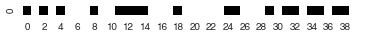

In [6]:
viz.matrix_plot(anc_phenotype)

### Define the system biochemistry (trait/resource interactions)

In [7]:
J = utils.random_matrix((L, L), 'tikhonov_sigmoid')

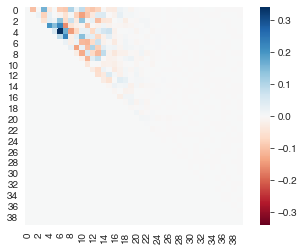

In [8]:
viz.matrix_plot(J)

### Parameterize and instantiate the Consumer-Resource System

In [9]:
anc_system = ConsumerResourceSystem(sigma=anc_phenotype, 
                                    b=1, 
                                    k=1e10,
                                    c=0.1, chi=0.5, J=J, 
                                    mu=1e-10,
                                    resource_consumption_mode='fast_resource_eq',
                                    resource_inflow_mode='none',
                                    threshold_min_rel_abundance=1e-6,
                                    N_init=1, R_init=1)

### Simulate dynamics

In [10]:
# just to pre-compile the dynamics njit function
# anc_system.dynamics(*((0,) + (np.zeros(L+L+1),) + anc_system.get_params()))

In [11]:
# anc_system.run(T=1000)

In [12]:
# %lprun -f anc_system.dynamics anc_system.run(T=1000)
# %lprun -f anc_system.handle_mutation_event anc_system.run(T=1000)

In [13]:
profiler = cProfile.Profile()
# %lprun -f anc_system.dynamics profiler.runcall(anc_system.run)
# %lprun -f ConsumerResourceSystem.growth_rate profile.runcall(anc_system.run)
# %lprun -f anc_system.event_low_abundance profiler.runcall(anc_system.run)
# %lprun -f TypeSet.add_type profiler.runcall(anc_system.run)
# %lprun -f TypeSet.generate_mutant_set profiler.runcall(anc_system.run)

%lprun -f anc_system.run profiler.runcall(anc_system.run)

Timer unit: 1e-06 s

Total time: 0.071358 s
File: /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py
Function: run at line 185

Line #      Hits         Time  Per Hit   % Time  Line Contents
   185                                               def run(self, T=10000, dt=None, integration_method='default'):
   186                                           
   187         1          8.0      8.0      0.0          t_start   = self.t
   188         1          2.0      2.0      0.0          t_elapsed = 0
   189                                           
   190                                                   # print(self.N_series, self.N_series.shape)
   191                                           
   192                                                   # print( np.zeros(shape=(self.N_series.shape[0], int(T/dt if dt is not None else T/0.1))) )
   193                                           
   194                               

In [14]:
ps = pstats.Stats(profiler)
ps.sort_stats('cumtime')
ps.print_stats()

         4194 function calls (4181 primitive calls) in 0.071 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    0.071    0.071 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:185(run)
      106    0.040    0.000    0.040    0.000 {built-in method numpy.concatenate}
        3    0.000    0.000    0.039    0.013 /usr/local/lib/python3.8/site-packages/numpy/core/shape_base.py:285(hstack)
        1    0.002    0.002    0.024    0.024 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py:156(solve_ivp)
       49    0.000    0.000    0.018    0.000 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py:159(step)
       49    0.001    0.000    0.017    0.000 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py:140(_step_impl)
       49    0.002    0.000    0.017    0.000 /usr/local/lib/python3.8/sit

### Visualize results

In [15]:
type_colors = viz.color_types_by_phylogeny(anc_system.type_set, apply_palette_depth=1)

<AxesSubplot:>

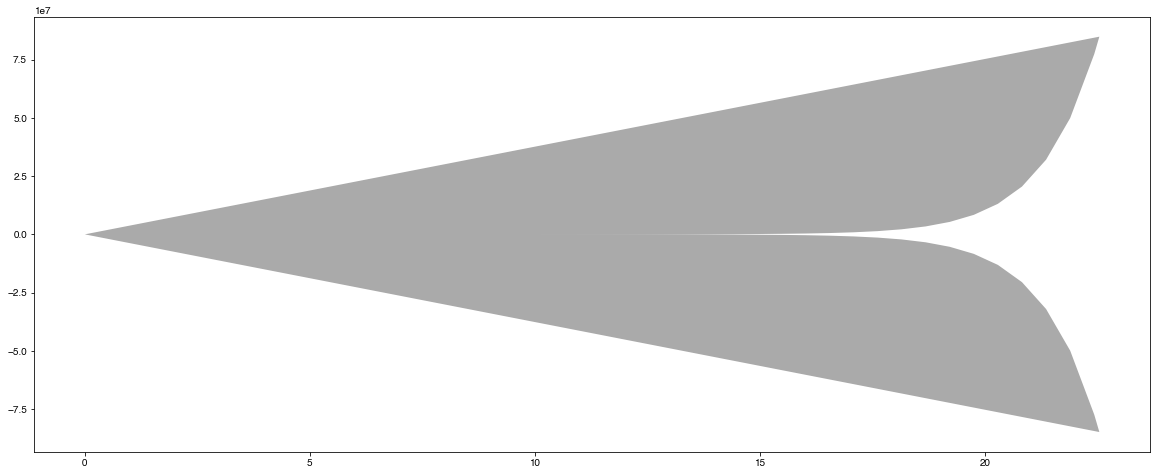

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(anc_system, ax=ax, type_colors=type_colors)

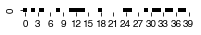

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_phenotype, ax=ax)

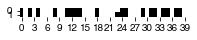

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.type_set.sigma, ax=ax)

In [19]:
anc_system.extant_type_indices

array([1])

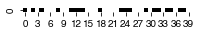

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.get_extant_type_set().sigma, ax=ax)

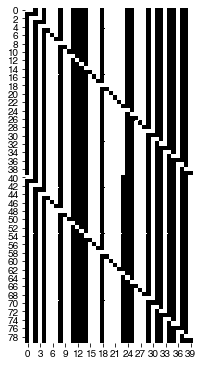

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.extant_mutant_set.sigma, ax=ax)

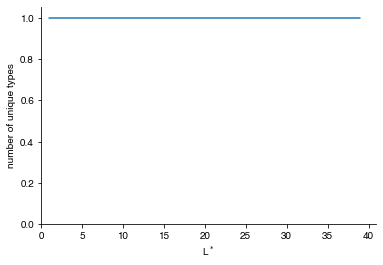

In [22]:
viz.Lstar_types_plot(anc_system)

In [23]:
N_end = anc_system.N_series[:,-1]
np.count_nonzero((N_end > 0) & (N_end < 1e4))

1

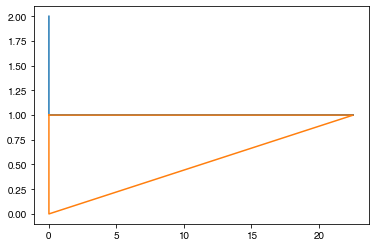

In [24]:
a = (anc_system.N_series > 0).argmax(axis=1)
n = []
for t_idx in range(anc_system.t_series.shape[0]):
    n.append(np.count_nonzero(a <= t_idx)) 
plt.plot(anc_system.t_series, n)
plt.plot(anc_system.t_series, (anc_system.N_series > 0).sum(axis=0))

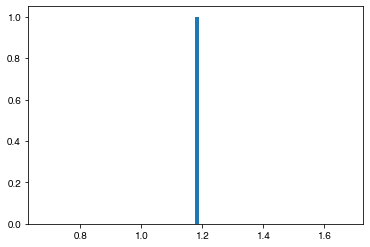

In [25]:
plt.hist(anc_system.N_series[(anc_system.N_series[:,-1]>0)&(anc_system.N_series[:,-1]<1e4),-1], bins=100)
# plt.xlim((0,100))
plt.show()

In [26]:
r = ConsumerResourceSystem.growth_rate(anc_system.N()[:, np.newaxis], anc_system.R(), anc_system.type_set.sigma, anc_system.type_set.b, anc_system.type_set.k, anc_system.type_set.eta, anc_system.type_set.l, anc_system.type_set.g, anc_system.type_set.energy_costs, anc_system.resource_set.omega, anc_system.resource_consumption_mode)

In [27]:
r[(anc_system.N() > 0) & (anc_system.N() < 1e4)] - np.mean(r[r > 0])

array([], dtype=float64)

In [28]:
r[r<0]

array([], dtype=float64)

In [29]:
anc_system.type_set.sigma.shape

(2, 40)

In [30]:
a = np.where(anc_system.N_series > 0)

In [31]:
anc_system.N()/np.sum(anc_system.N())

array([1., 0.])

In [32]:
anc_system.get_extant_types()


array([1])

In [33]:
1e3/1e10

1e-07

In [34]:
anc_system.type_set.mu.shape

()

In [35]:
anc_system.t_series.shape

(100001,)

In [36]:
anc_system.N_series.shape

(2, 100001)

In [37]:
anc_system.type_set.mutant_set.num_types

AttributeError: 'TypeSet' object has no attribute 'mutant_set'

In [ ]:
viz.matrix_plot(anc_system.type_set.sigma)

In [ ]:
viz.matrix_plot(anc_system.extant_mutant_set.sigma)